In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import root_mean_squared_error

In [2]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    return df

In [3]:
def preprocess_df(df):
    
    # calculate duration in minutes
    df["duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
    df["duration"] = df["duration"].apply(lambda td: td.total_seconds()/60)
    
    # filter riides to have only trips are between 1 and 60 mins. i.e. not too short nor too long
    df = df[(df["duration"] >= 1) & (df["duration"] <= 60)].copy()

    categorical = ["PULocationID", "DOLocationID"]

    df[categorical] = df[categorical].astype(str)
    df.loc[:,"PU_DO"] = df["PULocationID"] + "_" + df["DOLocationID"]

    return df

    


In [4]:
df_train = read_dataframe("data/green_tripdata_2024-01.parquet")
df_val = read_dataframe("data/green_tripdata_2024-02.parquet")

In [5]:
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.8,1.0,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.3,1.0,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.8,1.0,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.2,1.0,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.6,1.0,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00


In [6]:
df_val.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-02-01 00:15:53,2024-02-01 00:24:20,N,1.0,75,161,1.0,2.77,13.5,1.0,0.5,3.75,0.0,NaN,1.0,22.50,1.0,1.0,2.75
1,2,2024-01-31 22:59:22,2024-01-31 23:27:14,N,1.0,43,242,1.0,7.76,36.6,1.0,0.5,0.00,0.0,NaN,1.0,39.10,2.0,1.0,0.00
2,2,2024-02-01 00:30:29,2024-02-01 00:35:32,N,1.0,75,238,1.0,1.03,7.9,1.0,0.5,2.60,0.0,NaN,1.0,13.00,1.0,1.0,0.00
3,2,2024-01-31 23:56:42,2024-02-01 00:06:53,N,1.0,80,17,2.0,1.36,11.4,1.0,0.5,4.17,0.0,NaN,1.0,18.07,1.0,1.0,0.00
4,2,2024-02-01 00:31:14,2024-02-01 00:31:16,N,5.0,95,264,1.0,0.00,50.0,0.0,0.0,1.00,0.0,NaN,1.0,52.00,1.0,2.0,0.00


In [7]:
print(f"Training data: {df_train.shape[0]:,} rows, {df_train.shape[1]:,} cols")
print(f"Validation data: {df_val.shape[0]:,} rows, {df_val.shape[1]:,} cols")


Training data: 56,551 rows, 20 cols
Validation data: 53,577 rows, 20 cols


In [8]:
# Apply preprocessing

df_train = preprocess_df(df_train)
df_val = preprocess_df(df_val)

In [9]:
df_train["duration"].describe(percentiles=[0.95,0.98,0.99])

count    54373.000000
mean        13.778175
std          9.021503
min          1.000000
50%         11.566667
95%         31.850000
98%         40.885333
99%         47.026000
max         60.000000
Name: duration, dtype: float64

In [10]:
categorical = ["PU_DO"]#"PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient="records")

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [11]:
target = "duration"
y_train = df_train[target].values

y_val = df_val[target].values

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

5.9947992164797

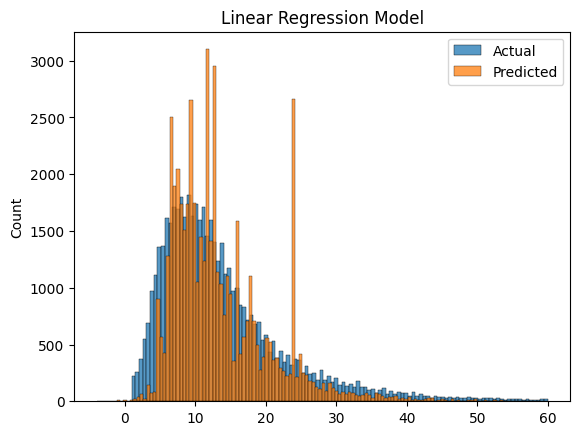

In [13]:
sns.histplot(y_val, label="Actual")
sns.histplot(y_pred, label="Predicted")
plt.legend()
plt.title("Linear Regression Model");

In [14]:
las = Lasso(alpha=0.01)
las.fit(X_train, y_train)

y_pred = las.predict(X_val)

root_mean_squared_error(y_val, y_pred)

8.029292935675121

In [15]:
rid = Ridge()
rid.fit(X_train, y_train)

y_pred = rid.predict(X_val)

root_mean_squared_error(y_val, y_pred)

5.978940889824404

#### Save best model

In [16]:
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv,lr), f_out)